This script offers a preliminary evaluation of a variant of the motif graph learning algorithm that considers the observations follow a GMRF whose precision matrix is given by a polynomial of the GSO.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

from sklearn.covariance import graphical_lasso
import src.utils as utils
import spectral_nti as snti

SEED = 28
N_CPUS = cpu_count()
np.random.seed(SEED)

PATH = './results/gmrf_st/'

## Auxiliary functions

In [13]:
def est_graph(id, models, MM, L, K, iters, verb=False):
    X = utils.create_GMRF_st_signals(L, K, MM[-1])

    N = X.shape[0]
    A_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i, M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()

            if model['name'] == 'GLasso':
                try:
                    _, L_hat = graphical_lasso(C_hat, model['alpha'], max_iter=iters)
                except FloatingPointError:
                    L_hat = np.zeros((N,N))
            elif model['St']:
                L_hat, _ = snti.MGL_Stationary_GMRF(C_hat, model['gs'], model['bounds'], 
                                                    model['cs'], model['regs'], max_iters=iters,
                                                    verbose=verb, epsilon=1e-5)
            else:
                L_hat, _ = snti.MGL(C_hat, model['gs'], model['bounds'], 
                                    model['cs'], model['regs'], max_iters=iters,
                                    verbose=verb, epsilon=1e-5)

            lamd_hat[:,j,i], _ = np.linalg.eigh(L_hat) 
            A_hat[:,:,j,i] = np.diag(np.diag(L_hat)) - L_hat
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {}-{} - Time(sec): {:.3}'.format(id, M, model['name'],  model['St'], t))
    return A_hat, lamd_hat


def est_errs(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                if np.all((A_hat[:,:,j,i,k] == 0)):
                    norm_A_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_A_hat = np.linalg.norm(A_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                A_hat_norm = A_hat[:,:,j,i,k]/norm_A_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_A[j,i,k] = np.linalg.norm(A/norm_A-A_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def est_errs2(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                err_A[j,i,k] = np.linalg.norm(A-A_hat[:,:,j,i,k],'fro')/norm_A
                err_lamb[j,i,k] = np.linalg.norm(lamd/-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def plot_err(MM, models, err, ylab, semlogy=True, ylim=[], skip=[]):
    plt.figure()
    for i, model in enumerate(models):
        if i in skip:
            continue
        if semlogy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Number of samples')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def print_err(MM, models, err):
    mean_err = np.mean(err, 2)
    std = np.std(err, 2)
    for i, M in enumerate(MM):
        print('M:', M)
        for j, model in enumerate(models):
            print('\t{}: mean err: {:.6f} - std: {:.6f}'.
                   format(model['name'], mean_err[j,i], std[j,i]))

## Create graphs

Norm of A: 7.874007874011811
Norm of lambdas: 16.248076809271918


Text(0.5, 1.0, 'True Lambdas, N: 20')

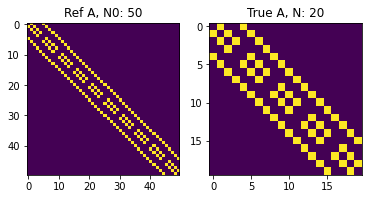

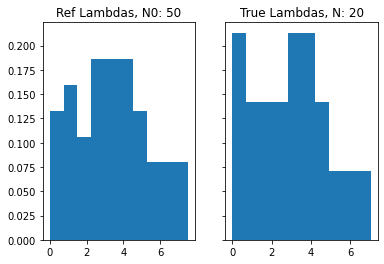

In [3]:
# Ref graph
n01 = 10
n02 = 5
N0 = n01*n02
A0 = nx.to_numpy_array(nx.grid_2d_graph(n01, n02))
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)

# Target graph
n1 = 5
n2 = 4
N = n1*n2
A = nx.to_numpy_array(nx.grid_2d_graph(n1, n2))
L = np.diag(np.sum(A, 0)) - A
lambdas, V = np.linalg.eigh(L)

norm_A = np.linalg.norm(A,'fro')
norm_lamb = np.linalg.norm(lambdas)

print('Norm of A:', norm_A)
print('Norm of lambdas:', norm_lamb)

# Plot graphs and spectrum distribution
plt.figure()
plt.subplot(1,2,1)
plt.imshow(A0)
plt.title('Ref A, N0: ' + str(N0))
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('True A, N: ' + str(N))
    
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

In [4]:
plt.rcParams['figure.facecolor'] = 'white'

## Compare contraints

In [5]:
n_covs = 50  #100
#MM = np.arange(300, 1501, 100)
MM = [50, 100, 150, 200, 250, 300, 350, 400]
K = 4
iters = 50 # 50

GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(cp.sqrt(a))/b,
    lambda a, b : cp.sum((.5*a-.75)**2)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b : cp.sum(lamd/cp.sqrt(lamd_t))/(2*b),
    lambda lamd, lamd_t, b: 1/b*(0.75-.5*lamd_t).T@lamd,
]

deltas = [.3, 2.1, .003, .1, .35]
cs, err_cs = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

models = [
    # Baseline
    {'St': False, 'name': 'GLasso', 'alpha': 0.1, 'fmt': '^:'},


    # With Stationarity
    {'St': True, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'eta': 1, 'inc_eta': 1.1,
              'deltas': deltas[0]}},

    {'St': True, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'eta': .05, 'inc_eta': 1.1,
              'deltas': deltas[1]}},

    {'St': True, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'eta': .1, 'inc_eta': 1.1, 
              'deltas': deltas[4]}},

    # Without Stationarity
    {'St': False, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'deltas': deltas[0]}},

    {'St': False, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o--',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'deltas': deltas[1]}},

    {'St': False, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'deltas': deltas[4]}},
]

	c-0: c: 3.100	c0: 3.400	err: -0.300000	err norm: -0.088235
	c-1: c: 13.200	c0: 15.360	err: -2.160000	err norm: -0.140625
	c-2: c: 0.125	c0: 0.125	err: -0.000055	err norm: -0.000437
	c-3: c: 1.636	c0: 1.735	err: -0.099287	err norm: -0.057224
	c-4: c: 1.509	c0: 1.841	err: -0.331875	err norm: -0.180244


In [6]:
# Estimate graph
verbose = False

total_t = time.time()
As_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, K, iters, verbose) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 64


Cov-24, M-50: Model: GLasso-False - Time(sec): 0.00904
Cov-12, M-50: Model: GLasso-False - Time(sec): 0.00866
Cov-26, M-50: Model: GLasso-False - Time(sec): 0.00718
Cov-17, M-50: Model: GLasso-False - Time(sec): 0.0147
Cov-33, M-50: Model: GLasso-False - Time(sec): 0.0186
Cov-14, M-50: Model: GLasso-False - Time(sec): 0.00621
Cov-6, M-50: Model: GLasso-False - Time(sec): 0.0071
Cov-4, M-50: Model: GLasso-False - Time(sec): 0.00723
Cov-8, M-50: Model: GLasso-False - Time(sec): 0.00839
Cov-25, M-50: Model: GLasso-False - Time(sec): 0.00727
Cov-13, M-50: Model: GLasso-False - Time(sec): 0.00945
Cov-10, M-50: Model: GLasso-False - Time(sec): 0.00892
Cov-18, M-50: Model: GLasso-False - Time(sec): 0.012
Cov-20, M-50: Model: GLasso-False - Time(sec): 0.0133
Cov-2, M-50: Model: GLasso-False - Time(sec): 0.0114
Cov-1, M-50: Model: GLasso-False - Time(sec): 0.0179
Cov-9, M-50: Model: GLasso-False - Time(sec): 0.0197
Cov-34, M-50: Model: GLasso-False - Time(sec): 0.00631
Cov-7, M-50: Model: GLass

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02653439419285064, tolerance: 0.011492341795325468
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07150201714293303, tolerance: 0.012974845259978694
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02827265197261397, tolerance: 0.012596820633360368
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/cova

Cov-21, M-50: Model: Tr-True - Time(sec): 17.2
Cov-1, M-50: Model: Tr-True - Time(sec): 19.0


/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-25, M-50: Model: Tr-True - Time(sec): 20.6


/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-35, M-50: Model: Tr-True - Time(sec): 22.5
Cov-8, M-50: Model: Tr-True - Time(sec): 23.2
Cov-11, M-50: Model: Tr-True - Time(sec): 24.2
Cov-6, M-50: Model: Tr-True - Time(sec): 24.2
Cov-13, M-50: Model: Tr-True - Time(sec): 24.6
Cov-7, M-50: Model: Tr-True - Time(sec): 25.7
Cov-32, M-50: Model: Tr-True - Time(sec): 26.3
Cov-30, M-50: Model: Tr-True - Time(sec): 26.8
Cov-46, M-50: Model: Tr-True - Time(sec): 28.0
Cov-28, M-50: Model: Tr-True - Time(sec): 28.3
Cov-10, M-50: Model: Tr-True - Time(sec): 28.3
Cov-38, M-50: Model: Tr-True - Time(sec): 28.6
Cov-15, M-50: Model: Tr-True - Time(sec): 28.7
Cov-27, M-50: Model: Tr-True - Time(sec): 28.7
Cov-24, M-50: Model: Tr-True - Time(sec): 30.3
Cov-17, M-50: Model: Tr-True - Time(sec): 30.4
Cov-23, M-50: Model: Tr-True - Time(sec): 30.9
Cov-37, M-50: Model: Tr-True - Time(sec): 31.2
Cov-3, M-50: Model: Tr-True - Time(sec): 31.8
Cov-14, M-50: Model: Tr-True - Time(sec): 31.9
Cov-41, M-50: Model: Tr-True - Time(sec): 33.2
Cov-1, M-50: Mode

/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-1, M-50: Model: Tr-False - Time(sec): 0.677
Cov-12, M-50: Model: Tr-True - Time(sec): 46.6
Cov-1, M-50: Model: Sq-False - Time(sec): 0.816
Cov-8, M-50: Model: Sq-True - Time(sec): 24.4
Cov-35, M-50: Model: Sq-True - Time(sec): 25.4
Cov-1, M-50: Model: BR-False - Time(sec): 0.746
Cov-1, M-100: Model: GLasso-False - Time(sec): 0.00519
Cov-25, M-50: Model: BR-True - Time(sec): 11.0
Cov-25, M-50: Model: Tr-False - Time(sec): 0.517
Cov-46, M-50: Model: Sq-True - Time(sec): 21.1
Cov-25, M-50: Model: Sq-False - Time(sec): 0.651
Cov-13, M-50: Model: Sq-True - Time(sec): 24.8
Cov-25, M-50: Model: BR-False - Time(sec): 0.77
Cov-25, M-100: Model: GLasso-False - Time(sec): 0.00838
Cov-16, M-50: Model: Tr-True - Time(sec): 50.5
Cov-9, M-50: Model: Tr-True - Time(sec): 50.6
Cov-21, M-50: Model: BR-True - Time(sec): 15.8
Cov-40, M-50: Model: Tr-True - Time(sec): 51.9
Cov-36, M-50: Model: Tr-True - Time(sec): 52.3
Cov-21, M-50: Model: Tr-False - Time(sec): 0.639
Cov-30, M-50: Model: Sq-True - Time

/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-21, M-50: Model: Sq-False - Time(sec): 0.759
Cov-29, M-50: Model: Tr-True - Time(sec): 53.3
Cov-6, M-50: Model: Sq-True - Time(sec): 29.5
Cov-43, M-50: Model: Tr-True - Time(sec): 53.8
Cov-21, M-50: Model: BR-False - Time(sec): 0.724
Cov-21, M-100: Model: GLasso-False - Time(sec): 0.00666
Cov-15, M-50: Model: Sq-True - Time(sec): 25.5
Cov-17, M-50: Model: Sq-True - Time(sec): 24.7
Cov-11, M-50: Model: Sq-True - Time(sec): 33.1
Cov-23, M-50: Model: Sq-True - Time(sec): 26.7


/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-32, M-50: Model: BR-True - Time(sec): 15.9
Cov-32, M-50: Model: Tr-False - Time(sec): 0.48
Cov-10, M-50: Model: Sq-True - Time(sec): 34.1
Cov-46, M-50: Model: BR-True - Time(sec): 13.5
Cov-32, M-50: Model: Sq-False - Time(sec): 0.569
Cov-28, M-50: Model: Sq-True - Time(sec): 34.7
Cov-46, M-50: Model: Tr-False - Time(sec): 0.454
Cov-32, M-50: Model: BR-False - Time(sec): 0.537
Cov-32, M-100: Model: GLasso-False - Time(sec): 0.00505
Cov-46, M-50: Model: Sq-False - Time(sec): 0.575
Cov-5, M-50: Model: Tr-True - Time(sec): 64.3
Cov-46, M-50: Model: BR-False - Time(sec): 0.502
Cov-46, M-100: Model: GLasso-False - Time(sec): 0.02
Cov-7, M-50: Model: Sq-True - Time(sec): 38.9
Cov-47, M-50: Model: Sq-True - Time(sec): 29.4
Cov-38, M-50: Model: Sq-True - Time(sec): 36.8
Cov-44, M-50: Model: Sq-True - Time(sec): 29.0
Cov-14, M-50: Model: Sq-True - Time(sec): 34.8
Cov-3, M-50: Model: Sq-True - Time(sec): 35.2
Cov-27, M-50: Model: Sq-True - Time(sec): 38.6
Cov-8, M-50: Model: BR-True - Time(se

/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-15, M-50: Model: Tr-False - Time(sec): 0.479
Cov-30, M-50: Model: Tr-False - Time(sec): 0.678
Cov-13, M-50: Model: Sq-False - Time(sec): 0.765
Cov-15, M-50: Model: Sq-False - Time(sec): 0.557
Cov-30, M-50: Model: Sq-False - Time(sec): 0.805
Cov-13, M-50: Model: BR-False - Time(sec): 0.766
Cov-13, M-100: Model: GLasso-False - Time(sec): 0.00994
Cov-15, M-50: Model: BR-False - Time(sec): 0.544
Cov-15, M-100: Model: GLasso-False - Time(sec): 0.00621
Cov-18, M-50: Model: Sq-True - Time(sec): 32.2
Cov-30, M-50: Model: BR-False - Time(sec): 0.771
Cov-30, M-100: Model: GLasso-False - Time(sec): 0.00807
Cov-23, M-50: Model: BR-True - Time(sec): 19.5
Cov-33, M-50: Model: Sq-True - Time(sec): 37.6
Cov-11, M-50: Model: BR-True - Time(sec): 20.1
Cov-31, M-50: Model: Sq-True - Time(sec): 44.0


/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cov-41, M-50: Model: Sq-True - Time(sec): 44.4
Cov-23, M-50: Model: Tr-False - Time(sec): 0.644
Cov-11, M-50: Model: Tr-False - Time(sec): 0.692
Cov-2, M-50: Model: Sq-True - Time(sec): 34.5
Cov-42, M-50: Model: Sq-True - Time(sec): 38.0
Cov-23, M-50: Model: Sq-False - Time(sec): 0.786
Cov-11, M-50: Model: Sq-False - Time(sec): 0.836
Cov-23, M-50: Model: BR-False - Time(sec): 0.748
Cov-23, M-100: Model: GLasso-False - Time(sec): 0.00991
Cov-11, M-50: Model: BR-False - Time(sec): 0.794
Cov-11, M-100: Model: GLasso-False - Time(sec): 0.00677
Cov-16, M-50: Model: Sq-True - Time(sec): 29.8
Cov-1, M-100: Model: Tr-True - Time(sec): 32.9
Cov-6, M-50: Model: BR-True - Time(sec): 27.3
Cov-6, M-50: Model: Tr-False - Time(sec): 0.684
Cov-40, M-50: Model: Sq-True - Time(sec): 29.8
Cov-0, M-50: Model: Sq-True - Time(sec): 39.1
Cov-6, M-50: Model: Sq-False - Time(sec): 0.827
Cov-26, M-50: Model: Sq-True - Time(sec): 47.4
Cov-28, M-50: Model: BR-True - Time(sec): 20.3
Cov-6, M-50: Model: BR-False - 

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 4.588e-03
  warnings.warn(


Cov-41, M-100: Model: Sq-False - Time(sec): 0.499
Cov-1, M-200: Model: BR-True - Time(sec): 9.02
Cov-41, M-100: Model: BR-False - Time(sec): 0.535
Cov-41, M-150: Model: GLasso-False - Time(sec): 0.00948
Cov-1, M-200: Model: Tr-False - Time(sec): 0.528
Cov-1, M-200: Model: Sq-False - Time(sec): 0.542
Cov-48, M-100: Model: Sq-True - Time(sec): 65.8
CONVERGENCE AT ITERATION: 4
Cov-21, M-200: Model: Sq-True - Time(sec): 3.07
Cov-1, M-200: Model: BR-False - Time(sec): 0.56
Cov-1, M-250: Model: GLasso-False - Time(sec): 0.00398
CONVERGENCE AT ITERATION: 27
Cov-25, M-150: Model: BR-True - Time(sec): 8.11
Cov-36, M-100: Model: Sq-True - Time(sec): 80.8
Cov-25, M-150: Model: Tr-False - Time(sec): 0.486
Cov-25, M-150: Model: Sq-False - Time(sec): 0.504
CONVERGENCE AT ITERATION: 2
Cov-21, M-200: Model: BR-True - Time(sec): 1.52
Cov-25, M-150: Model: BR-False - Time(sec): 0.542
Cov-25, M-200: Model: GLasso-False - Time(sec): 0.00501
Cov-28, M-150: Model: Tr-True - Time(sec): 24.5
Cov-21, M-200: Mo

/home/srey/.local/lib/python3.8/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: invalid value encountered in log
  return np.log(values[0])


Cov-34, M-150: Model: BR-False - Time(sec): 0.525
Cov-34, M-200: Model: GLasso-False - Time(sec): 0.00739
CONVERGENCE AT ITERATION: 2
Cov-3, M-250: Model: Sq-True - Time(sec): 2.3
Cov-31, M-150: Model: BR-False - Time(sec): 0.735
Cov-31, M-200: Model: GLasso-False - Time(sec): 0.0114
CONVERGENCE AT ITERATION: 2
Cov-10, M-200: Model: Sq-True - Time(sec): 4.57
Cov-32, M-200: Model: BR-True - Time(sec): 23.4
CONVERGENCE AT ITERATION: 2
Cov-8, M-400: Model: BR-True - Time(sec): 2.21
CONVERGENCE AT ITERATION: 2
Cov-40, M-300: Model: BR-True - Time(sec): 2.68
Cov-32, M-200: Model: Tr-False - Time(sec): 0.636
CONVERGENCE AT ITERATION: 2
Cov-6, M-200: Model: Sq-True - Time(sec): 2.23
Cov-8, M-400: Model: Tr-False - Time(sec): 0.691
Cov-40, M-300: Model: Tr-False - Time(sec): 0.631
Cov-32, M-200: Model: Sq-False - Time(sec): 0.711
CONVERGENCE AT ITERATION: 32
Cov-18, M-200: Model: BR-True - Time(sec): 20.2
Cov-8, M-400: Model: Sq-False - Time(sec): 0.725
Cov-40, M-300: Model: Sq-False - Time(se

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 6.593e-04
  warnings.warn(


CONVERGENCE AT ITERATION: 12
Cov-38, M-250: Model: Sq-True - Time(sec): 14.0
Cov-19, M-100: Model: Sq-True - Time(sec): 1.56e+02
Cov-42, M-150: Model: Tr-True - Time(sec): 1.65e+02
Cov-10, M-250: Model: BR-True - Time(sec): 20.5
CONVERGENCE AT ITERATION: 2
Cov-17, M-350: Model: Sq-True - Time(sec): 4.18
Cov-40, M-400: Model: Tr-True - Time(sec): 31.9
CONVERGENCE AT ITERATION: 2
Cov-11, M-350: Model: Sq-True - Time(sec): 1.71
Cov-10, M-250: Model: Tr-False - Time(sec): 0.441
CONVERGENCE AT ITERATION: 8
Cov-27, M-200: Model: BR-True - Time(sec): 6.61
CONVERGENCE AT ITERATION: 35
Cov-20, M-150: Model: BR-True - Time(sec): 16.7
Cov-10, M-250: Model: Sq-False - Time(sec): 0.48
Cov-27, M-200: Model: Tr-False - Time(sec): 0.409
Cov-20, M-150: Model: Tr-False - Time(sec): 0.428
Cov-10, M-250: Model: BR-False - Time(sec): 0.508
Cov-10, M-300: Model: GLasso-False - Time(sec): 0.00559
Cov-27, M-200: Model: Sq-False - Time(sec): 0.499
Cov-20, M-150: Model: Sq-False - Time(sec): 0.447
CONVERGENCE A

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019580206332506123, tolerance: 0.012782770904114097
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03287655366759168, tolerance: 0.012241166639379887
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Cov-2, M-300: Model: Tr-True - Time(sec): 32.2
Cov-12, M-300: Model: Tr-True - Time(sec): 32.0
Cov-3, M-400: Model: Tr-True - Time(sec): 35.8
CONVERGENCE AT ITERATION: 17
Cov-16, M-250: Model: Sq-True - Time(sec): 9.41
Cov-34, M-250: Model: Tr-True - Time(sec): 44.3
Cov-17, M-350: Model: BR-True - Time(sec): 15.6
CONVERGENCE AT ITERATION: 3
Cov-12, M-300: Model: Sq-True - Time(sec): 3.0
CONVERGENCE AT ITERATION: 2
Cov-3, M-400: Model: Sq-True - Time(sec): 2.91
Cov-17, M-350: Model: Tr-False - Time(sec): 0.451
Cov-17, M-350: Model: Sq-False - Time(sec): 0.503
CONVERGENCE AT ITERATION: 4
Cov-2, M-300: Model: Sq-True - Time(sec): 4.0
Cov-17, M-350: Model: BR-False - Time(sec): 0.514
Cov-17, M-400: Model: GLasso-False - Time(sec): 0.0101
CONVERGENCE AT ITERATION: 2
Cov-16, M-250: Model: BR-True - Time(sec): 2.04
Cov-16, M-250: Model: Tr-False - Time(sec): 0.406
CONVERGENCE AT ITERATION: 2
Cov-12, M-300: Model: BR-True - Time(sec): 1.93
Cov-16, M-250: Model: Sq-False - Time(sec): 0.456
CONV

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 1.239e-03
  warnings.warn(


CONVERGENCE AT ITERATION: 3
Cov-49, M-400: Model: BR-True - Time(sec): 2.4
Cov-0, M-350: Model: Tr-True - Time(sec): 38.6
Cov-49, M-400: Model: Tr-False - Time(sec): 0.405
CONVERGENCE AT ITERATION: 17
Cov-23, M-350: Model: Sq-True - Time(sec): 8.47
Cov-49, M-400: Model: Sq-False - Time(sec): 0.443
Cov-10, M-400: Model: Tr-True - Time(sec): 30.3
Cov-49, M-400: Model: BR-False - Time(sec): 0.447
Cov-41, M-400: Model: Tr-True - Time(sec): 39.9
Cov-35, M-350: Model: Tr-True - Time(sec): 30.2
CONVERGENCE AT ITERATION: 2
Cov-23, M-350: Model: BR-True - Time(sec): 1.74
Cov-23, M-350: Model: Tr-False - Time(sec): 0.367
Cov-24, M-350: Model: BR-True - Time(sec): 17.8
Cov-23, M-350: Model: Sq-False - Time(sec): 0.443
Cov-42, M-200: Model: Tr-True - Time(sec): 50.7
Cov-24, M-350: Model: Tr-False - Time(sec): 0.377
Cov-23, M-350: Model: BR-False - Time(sec): 0.421
Cov-23, M-400: Model: GLasso-False - Time(sec): 0.0078
Cov-24, M-350: Model: Sq-False - Time(sec): 0.421
Cov-24, M-350: Model: BR-False

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -1.222e-03
  warnings.warn(


Cov-22, M-250: Model: Tr-True - Time(sec): 32.6
Cov-38, M-400: Model: Tr-True - Time(sec): 28.3
CONVERGENCE AT ITERATION: 48
Cov-5, M-200: Model: BR-True - Time(sec): 22.6
Cov-5, M-200: Model: Tr-False - Time(sec): 0.396
CONVERGENCE AT ITERATION: 3
Cov-27, M-400: Model: BR-True - Time(sec): 3.19
Cov-5, M-200: Model: Sq-False - Time(sec): 0.411
CONVERGENCE AT ITERATION: 19
Cov-35, M-350: Model: Sq-True - Time(sec): 13.6
CONVERGENCE AT ITERATION: 5
Cov-4, M-400: Model: BR-True - Time(sec): 3.11
Cov-27, M-400: Model: Tr-False - Time(sec): 0.375
Cov-4, M-400: Model: Tr-False - Time(sec): 0.376
Cov-5, M-200: Model: BR-False - Time(sec): 0.419
Cov-5, M-250: Model: GLasso-False - Time(sec): 0.0114
Cov-27, M-400: Model: Sq-False - Time(sec): 0.422
CONVERGENCE AT ITERATION: 3
Cov-7, M-400: Model: Sq-True - Time(sec): 3.78
Cov-4, M-400: Model: Sq-False - Time(sec): 0.413
Cov-27, M-400: Model: BR-False - Time(sec): 0.42
Cov-4, M-400: Model: BR-False - Time(sec): 0.423
CONVERGENCE AT ITERATION: 2


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 2.740e-03
  warnings.warn(


CONVERGENCE AT ITERATION: 41
Cov-39, M-300: Model: Sq-True - Time(sec): 29.3
CONVERGENCE AT ITERATION: 2
Cov-39, M-300: Model: BR-True - Time(sec): 2.53
Cov-39, M-300: Model: Tr-False - Time(sec): 0.349
Cov-39, M-300: Model: Sq-False - Time(sec): 0.391
Cov-39, M-300: Model: BR-False - Time(sec): 0.4
Cov-39, M-350: Model: GLasso-False - Time(sec): 0.0172
Cov-37, M-350: Model: Tr-True - Time(sec): 61.5
CONVERGENCE AT ITERATION: 19
Cov-42, M-300: Model: BR-True - Time(sec): 60.9
Cov-39, M-350: Model: Tr-True - Time(sec): 33.4
Cov-42, M-300: Model: Tr-False - Time(sec): 0.353
Cov-42, M-300: Model: Sq-False - Time(sec): 0.406
Cov-42, M-300: Model: BR-False - Time(sec): 0.405
Cov-42, M-350: Model: GLasso-False - Time(sec): 0.014
CONVERGENCE AT ITERATION: 3
Cov-37, M-350: Model: Sq-True - Time(sec): 4.66
CONVERGENCE AT ITERATION: 3
Cov-39, M-350: Model: Sq-True - Time(sec): 4.4
CONVERGENCE AT ITERATION: 2
Cov-39, M-350: Model: BR-True - Time(sec): 2.81
Cov-39, M-350: Model: Tr-False - Time(se

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01959350035073726, tolerance: 0.014282703433348707
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01720393287550337, tolerance: 0.01425600796274232
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06593637101479999, tolerance: 0.014266418643138132
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covar

CONVERGENCE AT ITERATION: 3
Cov-37, M-350: Model: BR-True - Time(sec): 20.0
Cov-37, M-350: Model: Tr-False - Time(sec): 0.351
Cov-37, M-350: Model: Sq-False - Time(sec): 0.393
Cov-37, M-350: Model: BR-False - Time(sec): 0.402
Cov-37, M-400: Model: GLasso-False - Time(sec): 0.0341
CONVERGENCE AT ITERATION: 14
Cov-19, M-200: Model: Sq-True - Time(sec): 21.3
Cov-42, M-350: Model: Tr-True - Time(sec): 35.0
CONVERGENCE AT ITERATION: 4
Cov-42, M-350: Model: Sq-True - Time(sec): 5.06
Cov-39, M-400: Model: Tr-True - Time(sec): 36.5
CONVERGENCE AT ITERATION: 3
Cov-42, M-350: Model: BR-True - Time(sec): 4.14
Cov-42, M-350: Model: Tr-False - Time(sec): 0.351
Cov-42, M-350: Model: Sq-False - Time(sec): 0.394
Cov-42, M-350: Model: BR-False - Time(sec): 0.404
Cov-42, M-400: Model: GLasso-False - Time(sec): 0.011
CONVERGENCE AT ITERATION: 5
Cov-39, M-400: Model: Sq-True - Time(sec): 4.77
CONVERGENCE AT ITERATION: 13
Cov-19, M-200: Model: BR-True - Time(sec): 16.9
Cov-19, M-200: Model: Tr-False - Time

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 8.692e-03
  warnings.warn(


Cov-39, M-400: Model: Sq-False - Time(sec): 0.395
Cov-39, M-400: Model: BR-False - Time(sec): 0.402
CONVERGENCE AT ITERATION: 14
Cov-42, M-400: Model: Tr-True - Time(sec): 12.5
CONVERGENCE AT ITERATION: 4
Cov-42, M-400: Model: Sq-True - Time(sec): 6.29
Cov-37, M-400: Model: Tr-True - Time(sec): 50.3
CONVERGENCE AT ITERATION: 23
Cov-37, M-400: Model: Sq-True - Time(sec): 21.4
Cov-42, M-400: Model: BR-True - Time(sec): 31.8
Cov-42, M-400: Model: Tr-False - Time(sec): 0.372
Cov-42, M-400: Model: Sq-False - Time(sec): 0.391
Cov-42, M-400: Model: BR-False - Time(sec): 0.401
Cov-19, M-250: Model: Tr-True - Time(sec): 62.7
CONVERGENCE AT ITERATION: 3
Cov-19, M-250: Model: Sq-True - Time(sec): 5.44
Cov-37, M-400: Model: BR-True - Time(sec): 39.8
Cov-37, M-400: Model: Tr-False - Time(sec): 0.345
Cov-37, M-400: Model: Sq-False - Time(sec): 0.386
Cov-37, M-400: Model: BR-False - Time(sec): 0.394
Cov-19, M-250: Model: BR-True - Time(sec): 56.6
Cov-19, M-250: Model: Tr-False - Time(sec): 0.338
Cov-

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -5.703e-03
  warnings.warn(


Cov-45, M-150: Model: Sq-True - Time(sec): 1.3e+02
Cov-19, M-350: Model: Tr-True - Time(sec): 60.9
CONVERGENCE AT ITERATION: 15
Cov-19, M-350: Model: Sq-True - Time(sec): 19.8
Cov-19, M-350: Model: BR-True - Time(sec): 51.8
Cov-19, M-350: Model: Tr-False - Time(sec): 0.338
Cov-19, M-350: Model: Sq-False - Time(sec): 0.378
Cov-19, M-350: Model: BR-False - Time(sec): 0.385
Cov-19, M-400: Model: GLasso-False - Time(sec): 0.0497


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -3.529e-03
  warnings.warn(


CONVERGENCE AT ITERATION: 35
Cov-45, M-150: Model: BR-True - Time(sec): 87.0
Cov-45, M-150: Model: Tr-False - Time(sec): 0.341
Cov-45, M-150: Model: Sq-False - Time(sec): 0.384
Cov-45, M-150: Model: BR-False - Time(sec): 0.389
Cov-45, M-200: Model: GLasso-False - Time(sec): 0.0517


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03198977391221547, tolerance: 0.015210281421950729
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05056392134471821, tolerance: 0.015164679748784798
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036064040007431686, tolerance: 0.015460453455222206
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/cov

Cov-19, M-400: Model: Tr-True - Time(sec): 64.8
CONVERGENCE AT ITERATION: 2
Cov-19, M-400: Model: Sq-True - Time(sec): 4.15
Cov-19, M-400: Model: BR-True - Time(sec): 53.4
Cov-19, M-400: Model: Tr-False - Time(sec): 0.339
Cov-19, M-400: Model: Sq-False - Time(sec): 0.379
Cov-19, M-400: Model: BR-False - Time(sec): 0.386
Cov-45, M-200: Model: Tr-True - Time(sec): 1.35e+02
CONVERGENCE AT ITERATION: 3
Cov-45, M-200: Model: Sq-True - Time(sec): 9.11
CONVERGENCE AT ITERATION: 1
Cov-45, M-200: Model: BR-True - Time(sec): 3.89
Cov-45, M-200: Model: Tr-False - Time(sec): 0.338
Cov-45, M-200: Model: Sq-False - Time(sec): 0.378
Cov-45, M-200: Model: BR-False - Time(sec): 0.407
Cov-45, M-250: Model: GLasso-False - Time(sec): 0.00291


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021723245702105487, tolerance: 0.015986690185169152
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04232923511514741, tolerance: 0.016059232083717772
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.043127434207860915, tolerance: 0.01676269011190941
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/cov

Cov-45, M-250: Model: Tr-True - Time(sec): 1.48e+02
CONVERGENCE AT ITERATION: 5
Cov-45, M-250: Model: Sq-True - Time(sec): 16.8
Cov-45, M-250: Model: BR-True - Time(sec): 1.48e+02
Cov-45, M-250: Model: Tr-False - Time(sec): 0.339
Cov-45, M-250: Model: Sq-False - Time(sec): 0.378
Cov-45, M-250: Model: BR-False - Time(sec): 0.386
Cov-45, M-300: Model: GLasso-False - Time(sec): 0.00292


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02494548753045933, tolerance: 0.016546671926221643
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07659072601566663, tolerance: 0.01657529290394793
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07163977758605711, tolerance: 0.017163592841192458
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covar

Cov-45, M-300: Model: Tr-True - Time(sec): 1.55e+02
CONVERGENCE AT ITERATION: 2
Cov-45, M-300: Model: Sq-True - Time(sec): 7.52
Cov-45, M-300: Model: BR-True - Time(sec): 1.54e+02
Cov-45, M-300: Model: Tr-False - Time(sec): 0.338
Cov-45, M-300: Model: Sq-False - Time(sec): 0.378
Cov-45, M-300: Model: BR-False - Time(sec): 0.387
Cov-45, M-350: Model: GLasso-False - Time(sec): 0.00322


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022096523101367893, tolerance: 0.01660506115840759
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056397502577937075, tolerance: 0.016540852583605412
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07616300250808195, tolerance: 0.01720418868760711
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/cova

Cov-45, M-350: Model: Tr-True - Time(sec): 1.52e+02
CONVERGENCE AT ITERATION: 3
Cov-45, M-350: Model: Sq-True - Time(sec): 11.1
Cov-45, M-350: Model: BR-True - Time(sec): 1.41e+02
Cov-45, M-350: Model: Tr-False - Time(sec): 0.338
Cov-45, M-350: Model: Sq-False - Time(sec): 0.378
Cov-45, M-350: Model: BR-False - Time(sec): 0.387
Cov-45, M-400: Model: GLasso-False - Time(sec): 0.00321


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022116805605804757, tolerance: 0.016432448398061583
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06726611748609912, tolerance: 0.016547376088392546
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06562003839661656, tolerance: 0.017015753108795547
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/cov

Cov-45, M-400: Model: Tr-True - Time(sec): 1.7e+02
CONVERGENCE AT ITERATION: 2
Cov-45, M-400: Model: Sq-True - Time(sec): 8.6
CONVERGENCE AT ITERATION: 4
Cov-45, M-400: Model: BR-True - Time(sec): 14.3
Cov-45, M-400: Model: Tr-False - Time(sec): 0.338
Cov-45, M-400: Model: Sq-False - Time(sec): 0.378
Cov-45, M-400: Model: BR-False - Time(sec): 0.386
----- 44.23751879135768  mins -----


/tmp/ipykernel_4146350/4092026114.py:100: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


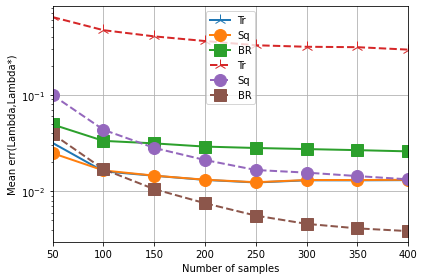

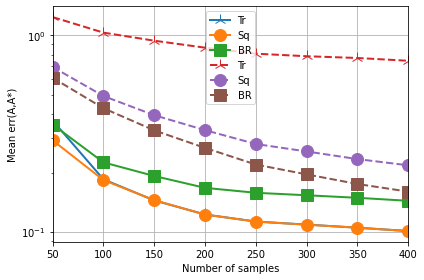

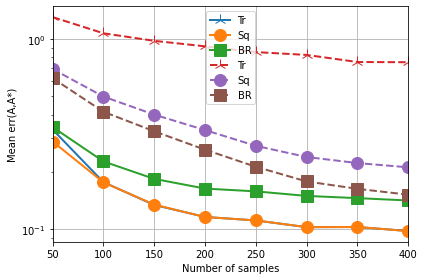

In [27]:
err_A, err_lamd = est_errs(A, lambdas, As_hat, lamds_hat, sq_err=True)
skip_idx = [0]

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)', skip=skip_idx)
plt.savefig(f'tmp/err_lamb_{iters}iters.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)', skip=skip_idx)
plt.savefig(f'tmp/err_A_{iters}iters.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)', skip=skip_idx)
plt.savefig(f'tmp/err_A_med_{iters}iters.png')



In [8]:
# Save np data
models_aux = [{'name': model['name'], 'St': model['St'], 'fmt': model['fmt']}
                for model in models]
data = {
    'A': A,
    'lambdas': lambdas,
    'lambdas0': lambdas0,
    'As_hat': As_hat,
    'lamds_hat': lamds_hat,
    'MM': MM,
    'models': models_aux
}
file = 'st_lattice_{}covs_{}iters'.format(n_covs, iters)
np.save(PATH + file, data)


In [9]:
# Save data as csv
# fname = PATH + 'constraints.csv'
# utils.error_to_csv(fname, models, MM, mean_err_lam)


In [26]:
# %matplotlib qt

# # Load data
# iters = 50
# file = PATH + f'/st_lattice_50covs_{iters}iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# lambdas0 = data['lambdas0']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']